In [13]:
import xarray as xr
import numpy as np
from huggingface_hub import HfFileSystem, hf_hub_download
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cProfile

In [11]:
fs = HfFileSystem()
all_files = fs.glob("datasets/LEAP/ClimSim_low-res-expanded/train/0001*/E3SM-MMF.mlexpand.*.nc")
print(len(all_files))

ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7edc6fcf-51d5-47db-af68-311550a7d35d)')

In [27]:
all_files[0]


'datasets/LEAP/ClimSim_low-res-expanded/train/0001-02/E3SM-MMF.mlexpand.0001-02-01-02400.nc'

In [4]:
def get_data_cols(nc):
    data_cols = []
    for col in X_cols_series_parents:
        arr = np.asarray(nc[col])
        arr = np.transpose(arr, [1,0])
        data_cols.append(arr)
    data_cols = np.concatenate(data_cols, axis = -1)
    return data_cols

In [7]:
for filename in all_files[:1]:
        filename = filename[39:]
        mli_file = hf_hub_download(repo_id="LEAP/ClimSim_low-res-expanded", filename=filename, repo_type="dataset")
        array = xr.open_dataset(mli_file)
        #data_cols = get_data_cols(nc)
        

In [35]:
array

<xarray.Dataset> Size: 6MB
Dimensions:                (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/61)
    ymd                    int32 4B ...
    tod                    int32 4B ...
    cam_in_ALDIF           (ncol) float64 3kB ...
    cam_in_ALDIR           (ncol) float64 3kB ...
    cam_in_ASDIF           (ncol) float64 3kB ...
    cam_in_ASDIR           (ncol) float64 3kB ...
    ...                     ...
    tm_pbuf_COSZRS         (ncol) float64 3kB ...
    lat                    (ncol) float64 3kB ...
    lon                    (ncol) float64 3kB ...
    clat                   (ncol) float64 3kB ...
    slat                   (ncol) float64 3kB ...
    icol                   (ncol) float64 3kB ...
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [38]:
len(array['state_ps'].values)

384

In [79]:
array.dims

FrozenMappingWarningOnValuesAccess({'ncol': 384, 'lev': 60})

In [78]:
array['state_t'].unstack()

<xarray.DataArray 'state_t' (lev: 60, ncol: 384)> Size: 184kB
array([[213.692457, 213.420258, 216.781858, ..., 223.195444, 222.766036,
        227.974324],
       [221.977391, 225.439016, 219.180464, ..., 230.103536, 236.639254,
        234.354333],
       [228.300332, 228.466856, 233.8395  , ..., 230.096289, 236.097236,
        241.058127],
       ...,
       [291.795769, 288.524605, 294.998005, ..., 260.55719 , 262.128751,
        267.879348],
       [293.037831, 289.735945, 296.226938, ..., 260.484081, 263.249186,
        269.008277],
       [294.28734 , 290.970945, 297.482457, ..., 259.699987, 264.550574,
        270.229729]], shape=(60, 384))
Dimensions without coordinates: lev, ncol

In [2]:
path = '/Users/katiefrields/Projects/climsimdata/E3SM-MMF.mli.0001-03-01-00000.nc'
mli_dataset = xr.open_dataset(path)


In [13]:
info_path = '/Users/katiefrields/Documents/GitHub/climsim3/grid_info/ClimSim_low-res_grid-info.nc'
grid_info = xr.open_dataset(info_path)
lon = grid_info['lon'].values
lat = grid_info['lat'].values
lon = ((lon + 180) % 360) - 180

In [ ]:
def plot_raw_variable_hist(variable,axis, label = 'x'):
    plt.figure(figsize=(10, 5))
    plt.hist(variable.values, bins=100)
    plt.title(label)
    plt.show()


plot_raw_variable_hist(array['state_ps'], 'State Pressure')



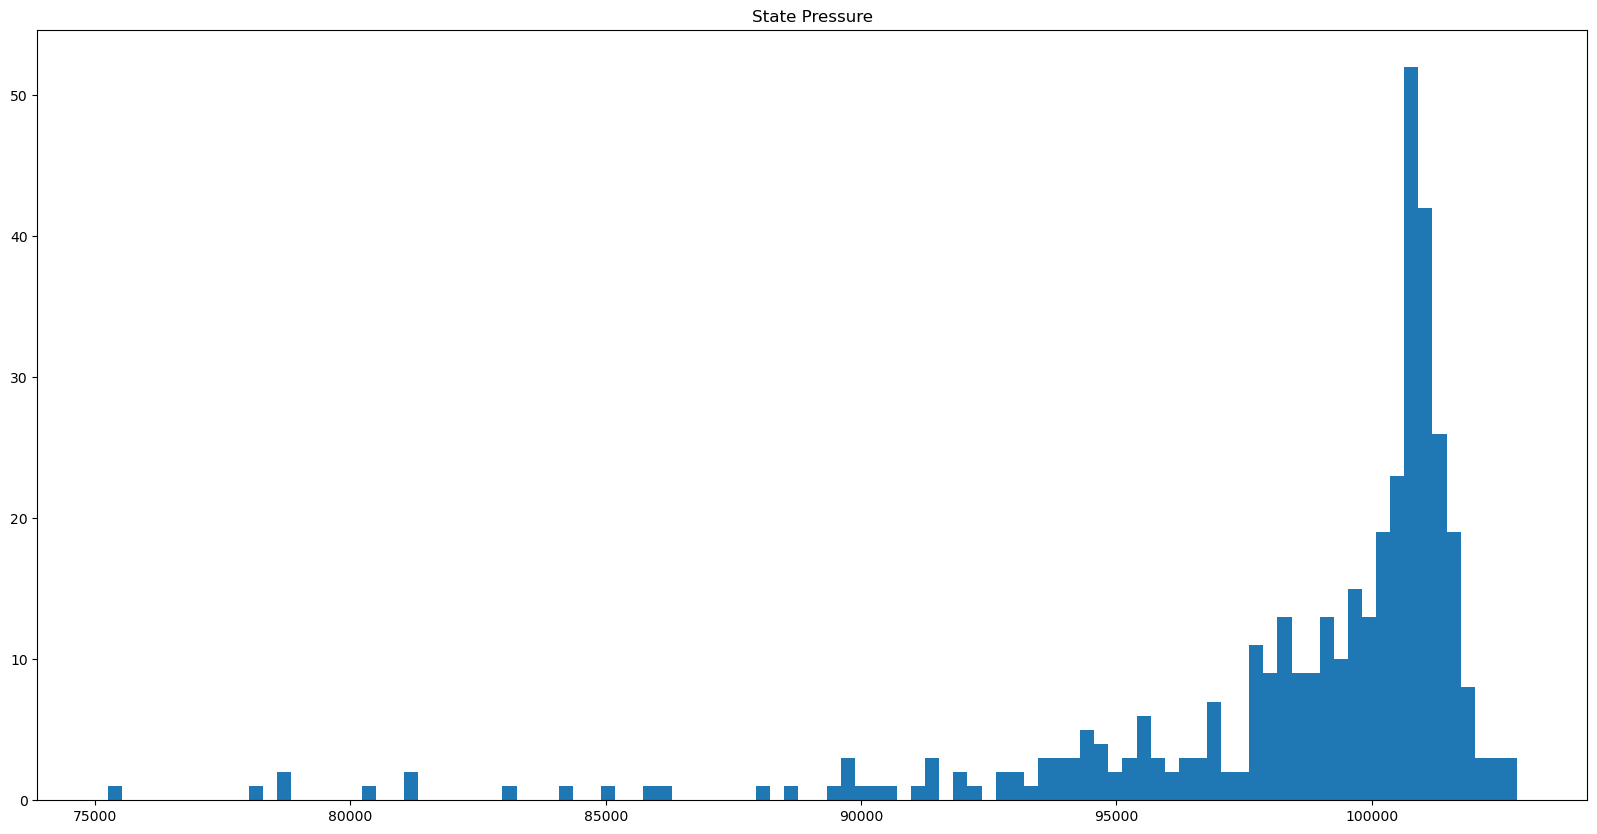

In [28]:
def plot_raw_variable_hist(variable,label = 'x', pdf_pages = None):
    fig, ax = plt.subplots(1, 1, figsize = (20,10))  
    ax.hist(variable.values, bins=100)
    plt.title(label)
    plt.show()
    if pdf_pages is not None:
        pdf_pages.savefig(fig)
    plt.close()
    

plot_raw_variable_hist(array['state_ps'], 'State Pressure')



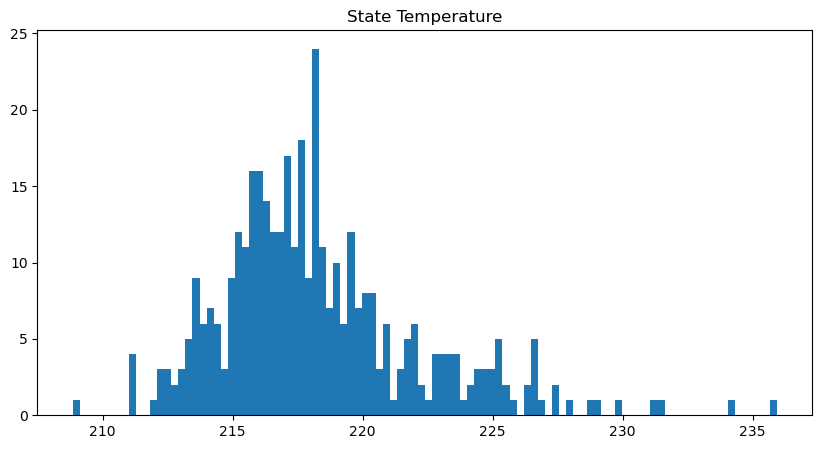

In [ ]:

plot_raw_variable_hist(array['state_t'].sel(lev=0), 'State Temperature')

In [212]:
variable.values.flatten()

array([213.69245661, 213.42025845, 216.78185776, ..., 259.69998688,
       264.5505742 , 270.22972903], shape=(23040,))

In [213]:
variable = array['state_t']
stacked = variable.stack(var = ("lev", "ncol"))

stacked['lev']

<xarray.DataArray 'lev' (var: 23040)> Size: 184kB
array([ 0,  0,  0, ..., 59, 59, 59], shape=(23040,))
Coordinates:
  * var      (var) object 184kB MultiIndex
  * lev      (var) int64 184kB 0 0 0 0 0 0 0 0 0 ... 59 59 59 59 59 59 59 59 59
  * ncol     (var) int64 184kB 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383

In [ ]:
lev_values = np.array([t[0] for t in stacked['var'].values])
temp_values = np.array([t[1] for t in stacked['var'].values])

/var/folders/dm/cwmd0_bn1lg6rxgh_wfkctpc0000gn/T/ipykernel_54300/336689525.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


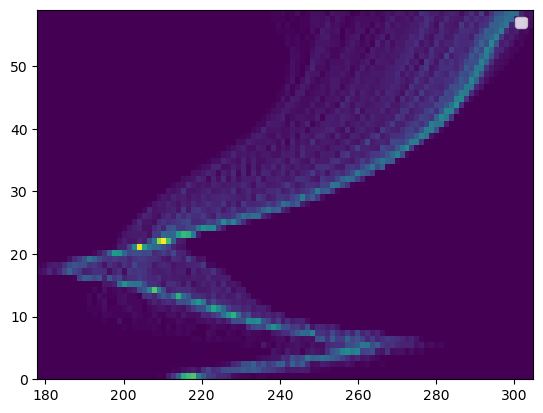

In [215]:
plt.hist2d(variable.values.flatten(),  stacked['lev'], bins = (100, 60))
plt.legend()
plt.show()

In [ ]:

'''
    variable: xarray of the variable you want to plot
'''
def plot_layered_variable_hist(variable, label = 'x', bins = 100, pdf_pages = None):
    
    flat_values = variable.values.flatten()

    stacked = variable.stack(var = ("lev", "ncol"))
    fig, ax = plt.subplots()

    plt.xlabel(label)
    plt.ylabel('Level')
    #ax.invert_yaxis
    ax.hist2d(flat_values, stacked['lev'], bins=(bins,60))
    plt.title(f'{label} vs Level')
    plt.show()
    if pdf_pages is not None:
        pdf_pages.savefig(fig)
    plt.close()


plot_layered_variable_hist(array['state_t'], 'State Temperature')



NameError: name 'array' is not defined

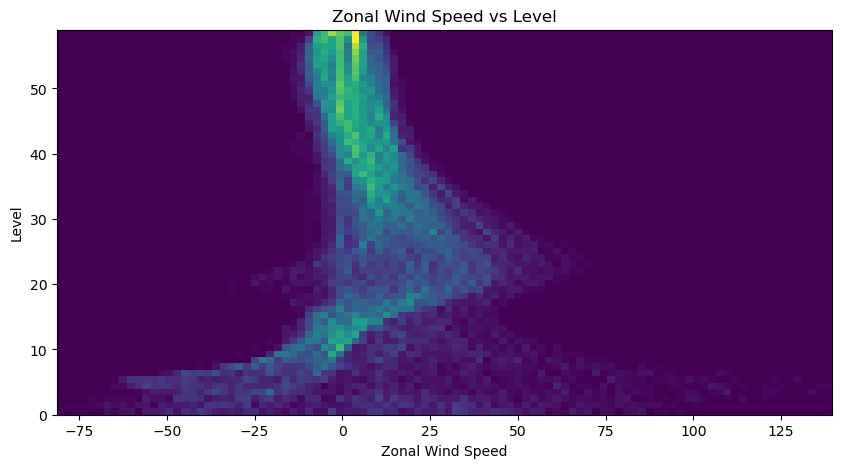

In [223]:

plot_layered_variable_hist(array['state_u'], 'Zonal Wind Speed')

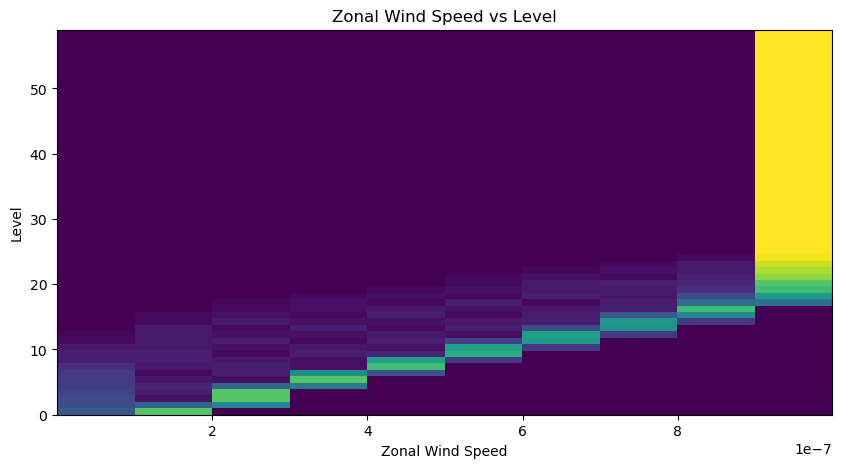

In [233]:

plot_layered_variable_hist(array['pbuf_CH4'], 'Zonal Wind Speed', bins = 10)


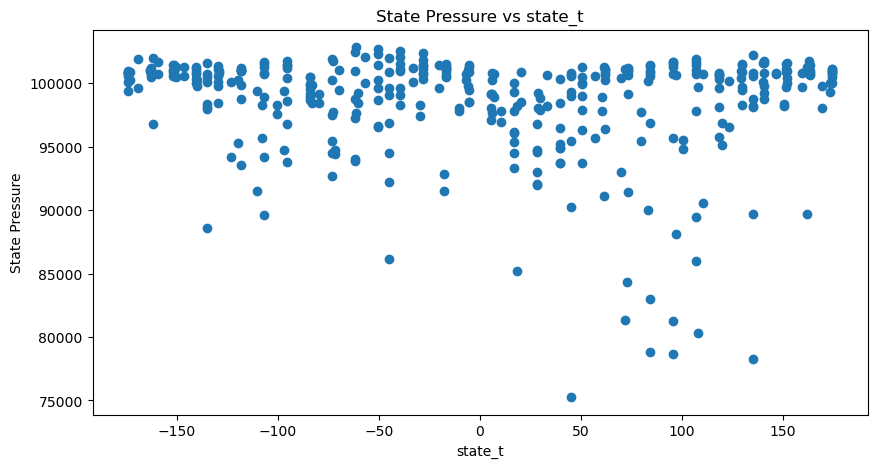

In [55]:
def plot_raw_variable_scatter(x_variable, y_variable, x_label = 'x', y_label = 'y'):
    plt.figure(figsize=(10, 5))
    plt.scatter(x_variable, y_variable)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(y_label + ' vs ' + x_label)
    plt.show()


plot_raw_variable(lon, array['state_ps'].values, 'state_t', 'State Pressure')



In [30]:

def plot_map(variable, title_text, pdf_pages = None):
    # Create a figure and axis with a Robinson projection
    values = variable.values
    
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6)
    )

    # Add filled contours to the map
    contour = ax.tricontourf(
        lon, lat, values, 
        transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
        cmap='coolwarm',  # Adjust colormap as needed
        levels=20,  # Number of contour levels
        extend='both'  # Extend beyond data range
    )

    # Add features like coastlines and borders
    ax.coastlines(linewidth=0.5, color='black')

    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Temperature (K)')  # Adjust label to match your data

    # Set title
    ax.set_title('Global ' + title_text + ' - Robinson Projection', fontsize=16)
    ax.set_global()

    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    # Show the plot
    plt.show()
    if pdf_pages is not None:
        pdf_pages.savefig(fig)
    plt.close()

#add it so that the 0th level is always taken
#plot_map(array['state_t'].values[59],'State Pressure')


NEXT: work on plotting the range of variables vs temperature

order ncols by surface temperature and plot the ranges or value of the variable (depending on if the value varies over level)

idea: splitting the tropopause into levels for temperature



In [35]:
list(array.variables)

['ymd',
 'tod',
 'cam_in_ALDIF',
 'cam_in_ALDIR',
 'cam_in_ASDIF',
 'cam_in_ASDIR',
 'cam_in_ICEFRAC',
 'cam_in_LANDFRAC',
 'cam_in_LWUP',
 'cam_in_OCNFRAC',
 'cam_in_SNOWHICE',
 'cam_in_SNOWHLAND',
 'pbuf_COSZRS',
 'pbuf_LHFLX',
 'pbuf_SHFLX',
 'pbuf_SOLIN',
 'pbuf_TAUX',
 'pbuf_TAUY',
 'state_pmid',
 'state_ps',
 'state_q0001',
 'state_q0002',
 'state_q0003',
 'state_t',
 'state_u',
 'state_v',
 'pbuf_CH4',
 'pbuf_N2O',
 'pbuf_ozone',
 'tm_state_t',
 'tm_state_q0001',
 'tm_state_q0002',
 'tm_state_q0003',
 'tm_state_u',
 'tm_state_v',
 'state_t_prvphy',
 'state_q0001_prvphy',
 'state_q0002_prvphy',
 'state_q0003_prvphy',
 'state_u_prvphy',
 'tm_state_t_prvphy',
 'tm_state_q0001_prvphy',
 'tm_state_q0002_prvphy',
 'tm_state_q0003_prvphy',
 'tm_state_u_prvphy',
 'state_t_dyn',
 'state_q0_dyn',
 'state_u_dyn',
 'tm_state_t_dyn',
 'tm_state_q0_dyn',
 'tm_state_u_dyn',
 'tm_state_ps',
 'tm_pbuf_SOLIN',
 'tm_pbuf_SHFLX',
 'tm_pbuf_LHFLX',
 'tm_pbuf_COSZRS',
 'lat',
 'lon',
 'clat',
 'slat'

In [245]:
len(list(array.variables))

61

In [243]:
len(array['cam_in_ALDIF'].dims)


1

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_filename = "/Users/katiefrields/Desktop/climsim variables/single.pdf"
pdf_pages = PdfPages(pdf_filename)

plot_raw_variable_hist(array['cam_in_ALDIF'],'cam_in_ALDIF', pdf_pages=pdf_pages)
plot_map(array['cam_in_ALDIF'],'cam_in_ALDIF', pdf_pages)

pdf_pages.close()




In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
pdf_filename = "/Users/katiefrields/Desktop/climsim variables/multiple_plots.pdf"
pdf_pages = PdfPages(pdf_filename)

for variable in list(array.variables):
   
    dim_count = len(array[variable].dims)

    if dim_count == 1:
        plot_raw_variable_hist(array[variable],variable, pdf_pages=pdf_pages)
        plot_map(array[variable],variable, pdf_pages)
    if dim_count == 2:
        plot_layered_variable_hist(array[variable],variable, pdf_pages=pdf_pages)
        
pdf_pages.close()


In [ ]:


fig, ax = plt.subplots(61, 2, figsize = (20,20))  
variable_count = 0

for variable in list(array.variables):
    dim_count = len(array[variable].dims)

    if dim_count == 1:
        #plot_raw_variable_hist(array[variable], variable)
        ax[variable_count, 0].hist(array[variable].values, bins=100)

        #plot_raw_variable_scatter(x_variable, y_variable, x_label = 'x', y_label = 'y')

    variable_count+=1



    
 


#plt.savefig()

In [11]:
grid_info



<xarray.Dataset> Size: 14kB
Dimensions:  (time: 1, ncol: 384, ilev: 61, lev: 60)
Coordinates:
  * ilev     (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev      (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
Dimensions without coordinates: time, ncol
Data variables:
    P0       float64 8B ...
    PS       (time, ncol) float32 2kB ...
    area     (ncol) float64 3kB ...
    hyai     (ilev) float64 488B ...
    hyam     (lev) float64 480B ...
    hybi     (ilev) float64 488B ...
    hybm     (lev) float64 480B ...
    lat      (ncol) float64 3kB -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
    lon      (ncol) float64 3kB 320.3 331.5 320.4 331.7 ... 123.3 146.7 135.0
Attributes: (12/19)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

In [136]:
type(mli_dataset)

xarray.core.dataset.Dataset

In [137]:
mli_dataset.values

<bound method Mapping.values of <xarray.Dataset> Size: 2MB
Dimensions:           (ncol: 384, lev: 60)
Dimensions without coordinates: ncol, lev
Data variables: (12/29)
    ymd               int32 4B ...
    tod               int32 4B ...
    cam_in_ALDIF      (ncol) float64 3kB ...
    cam_in_ALDIR      (ncol) float64 3kB ...
    cam_in_ASDIF      (ncol) float64 3kB ...
    cam_in_ASDIR      (ncol) float64 3kB ...
    ...                ...
    state_t           (lev, ncol) float64 184kB ...
    state_u           (lev, ncol) float64 184kB ...
    state_v           (lev, ncol) float64 184kB ...
    pbuf_CH4          (lev, ncol) float64 184kB ...
    pbuf_N2O          (lev, ncol) float64 184kB ...
    pbuf_ozone        (lev, ncol) float64 184kB ...
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP>

In [138]:
mli_dataset.dims


FrozenMappingWarningOnValuesAccess({'ncol': 384, 'lev': 60})

In [139]:
mli_dataset.data_vars

Data variables:
    ymd               int32 4B ...
    tod               int32 4B ...
    cam_in_ALDIF      (ncol) float64 3kB ...
    cam_in_ALDIR      (ncol) float64 3kB ...
    cam_in_ASDIF      (ncol) float64 3kB ...
    cam_in_ASDIR      (ncol) float64 3kB ...
    cam_in_ICEFRAC    (ncol) float64 3kB ...
    cam_in_LANDFRAC   (ncol) float64 3kB ...
    cam_in_LWUP       (ncol) float64 3kB ...
    cam_in_OCNFRAC    (ncol) float64 3kB ...
    cam_in_SNOWHICE   (ncol) float64 3kB ...
    cam_in_SNOWHLAND  (ncol) float64 3kB ...
    pbuf_COSZRS       (ncol) float64 3kB ...
    pbuf_LHFLX        (ncol) float64 3kB ...
    pbuf_SHFLX        (ncol) float64 3kB ...
    pbuf_SOLIN        (ncol) float64 3kB ...
    pbuf_TAUX         (ncol) float64 3kB ...
    pbuf_TAUY         (ncol) float64 3kB ...
    state_pmid        (lev, ncol) float64 184kB ...
    state_ps          (ncol) float64 3kB ...
    state_q0001       (lev, ncol) float64 184kB ...
    state_q0002       (lev, ncol) float64 184

In [141]:
mli_dataset['cam_in_SNOWHICE'].values



array([1.00000000e+30, 1.00000000e+30, ..., 1.30158566e-01,
       1.00000000e+30])

In [142]:
type(mli_dataset['cam_in_SNOWHICE'])

xarray.core.dataarray.DataArray

In [143]:
mli_dataset['cam_in_SNOWHICE'].shape

(384,)

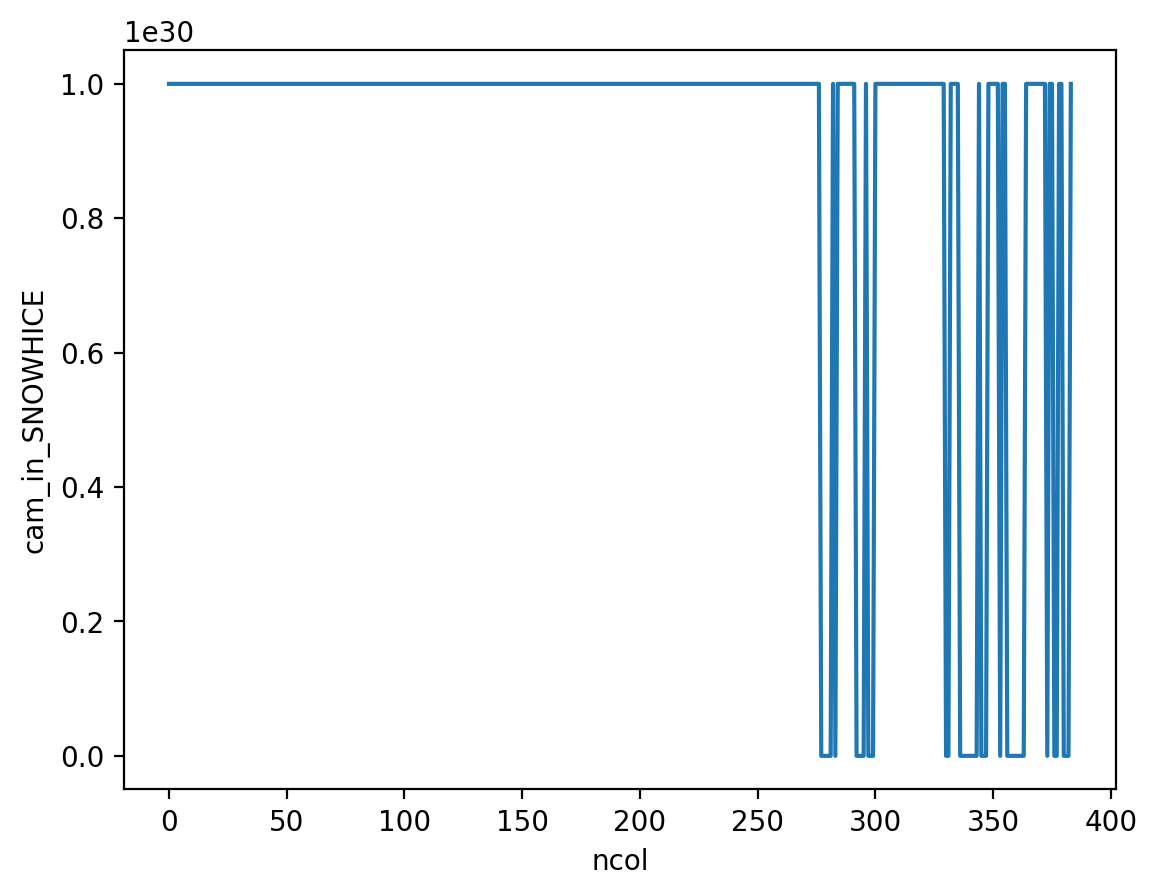

In [144]:
mli_dataset['cam_in_SNOWHICE'].plot()

In [145]:
mli_dataset['state_q0001']

<xarray.DataArray 'state_q0001' (lev: 60, ncol: 384)> Size: 184kB
[23040 values with dtype=float64]
Dimensions without coordinates: lev, ncol

In [146]:
grid_path = '/Users/katiefrields/Documents/GitHub/climsim3/grid_info/ClimSim_low-res_grid-info.nc'
grid_info = xr.open_dataset(grid_path)

In [147]:
grid_info.data_vars

Data variables:
    P0       float64 8B ...
    PS       (time, ncol) float32 2kB ...
    area     (ncol) float64 3kB ...
    hyai     (ilev) float64 488B ...
    hyam     (lev) float64 480B ...
    hybi     (ilev) float64 488B ...
    hybm     (lev) float64 480B ...
    lat      (ncol) float64 3kB ...
    lon      (ncol) float64 3kB ...

In [148]:
grid_info['lat']

<xarray.DataArray 'lat' (ncol: 384)> Size: 3kB
[384 values with dtype=float64]
Dimensions without coordinates: ncol
Attributes:
    long_name:  latitude
    units:      degrees_north

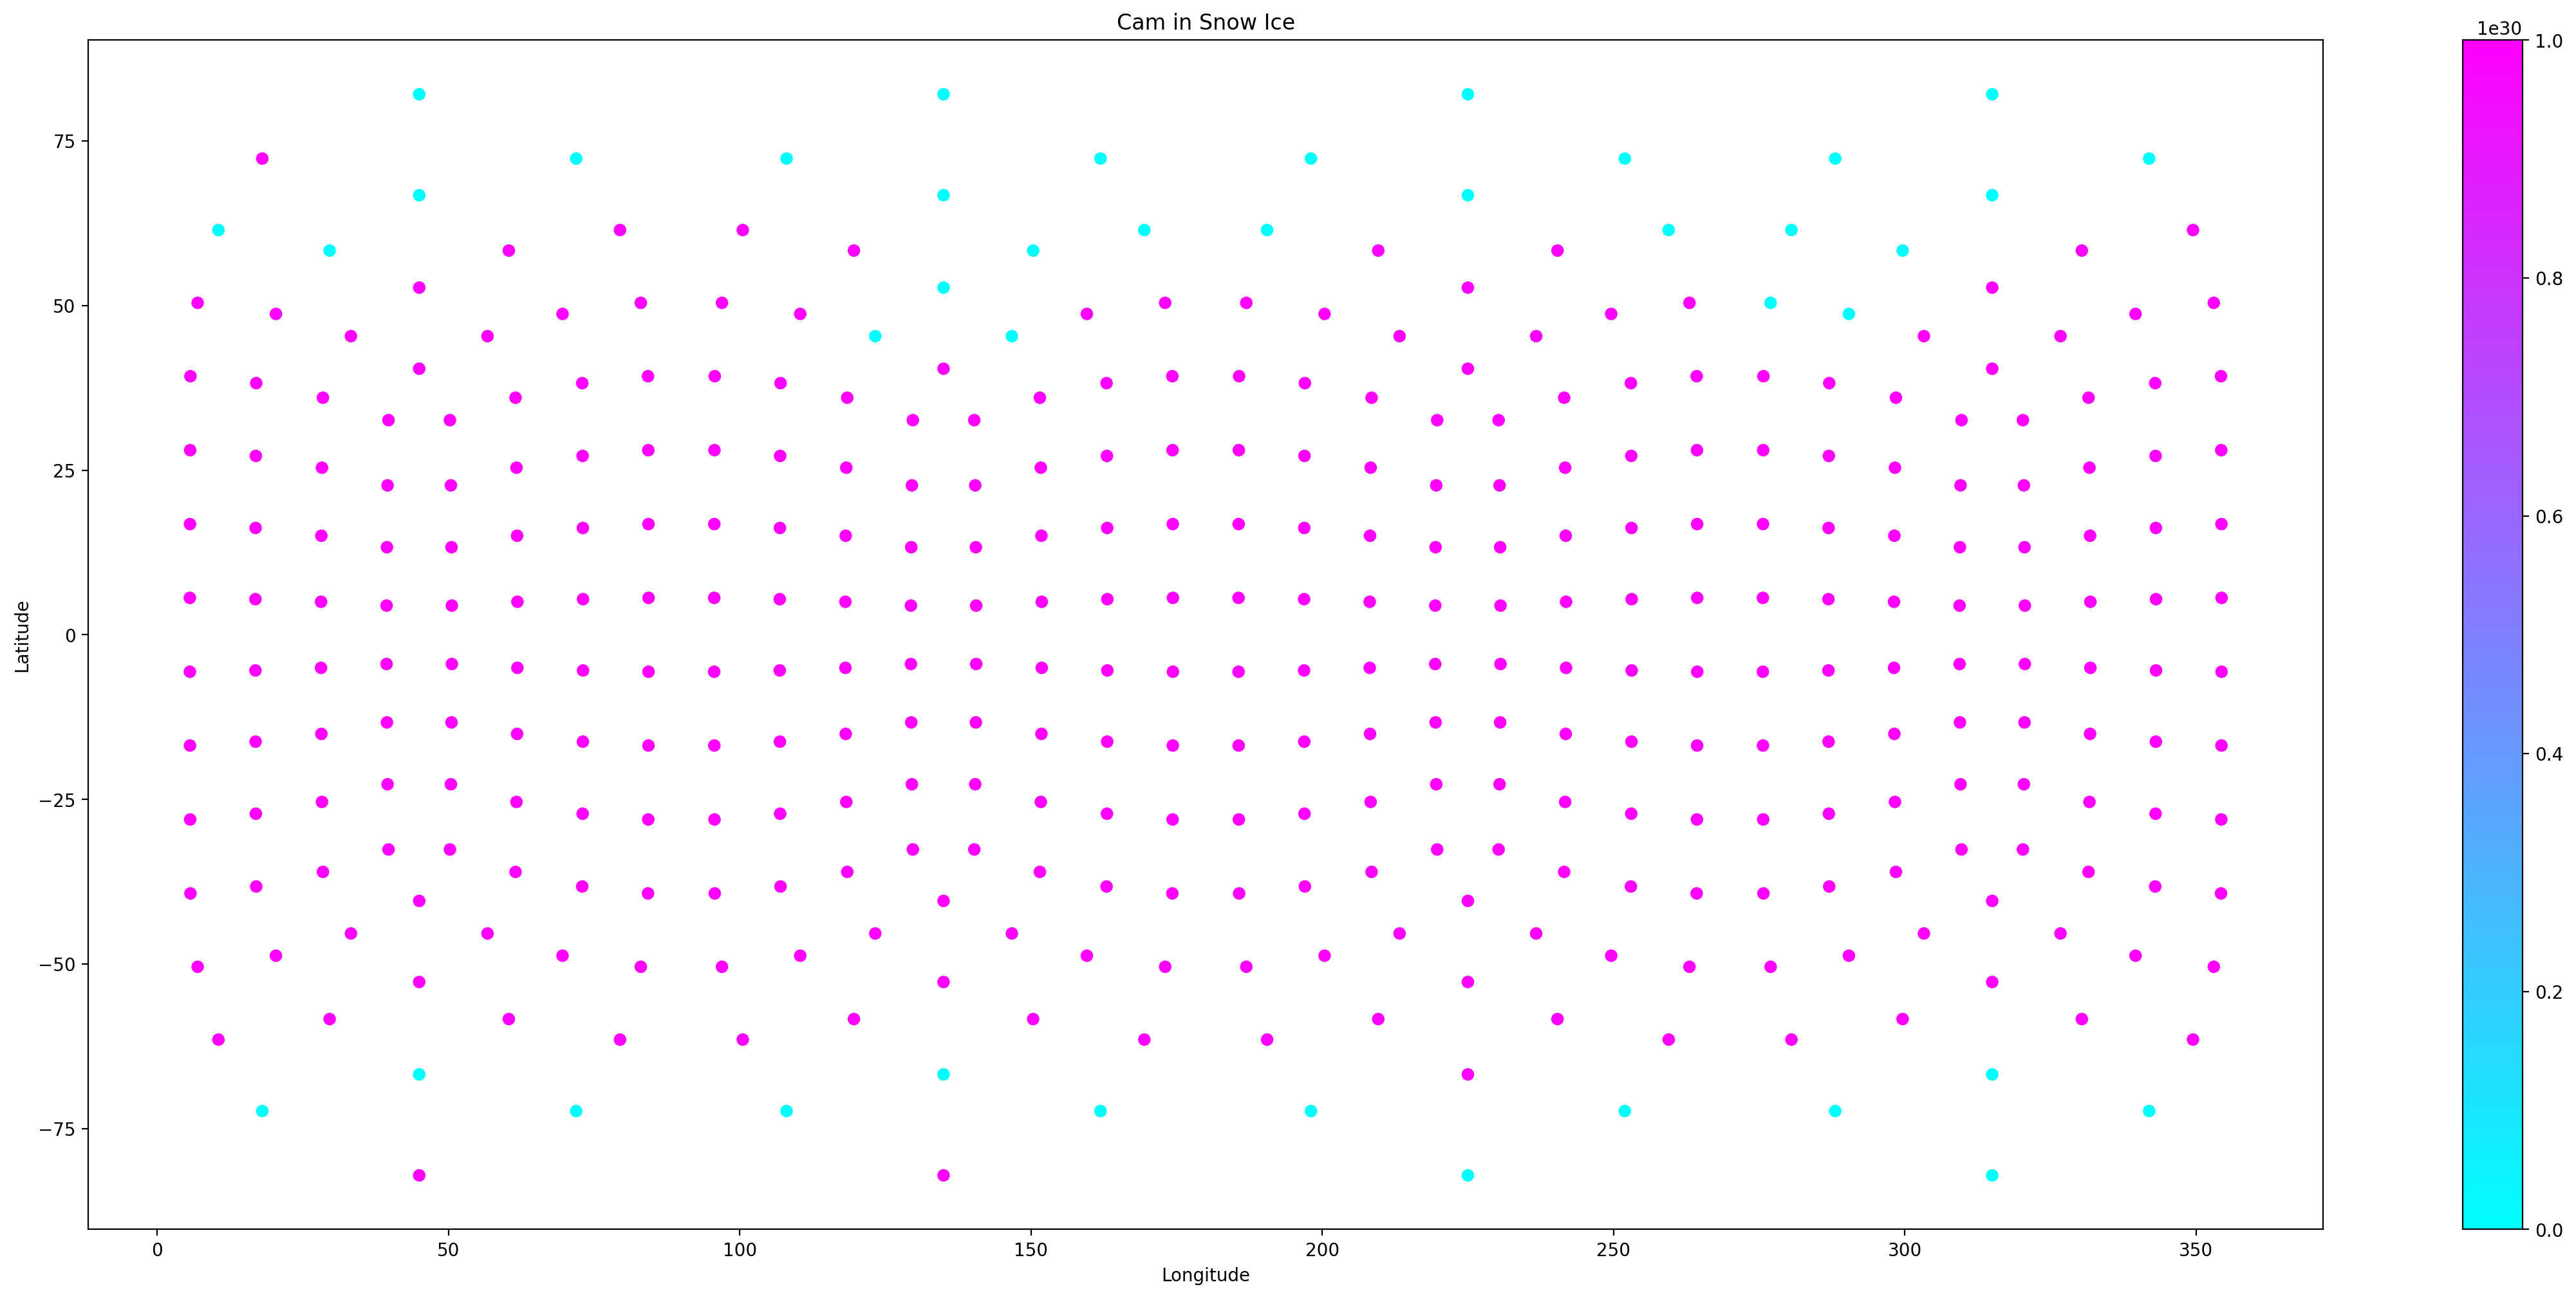

In [149]:
plt.figure(figsize=(28,12))
plt.scatter(grid_info['lon'], grid_info['lat'], c=mli_dataset['cam_in_SNOWHICE'], cmap='cool')
plt.xlabel('Longitude'), plt.ylabel('Latitude'), plt.title('Cam in Snow Ice')
plt.colorbar()

In [150]:
#select the one level of the ozone
mli_dataset['pbuf_ozone']

<xarray.DataArray 'pbuf_ozone' (lev: 60, ncol: 384)> Size: 184kB
[23040 values with dtype=float64]
Dimensions without coordinates: lev, ncol

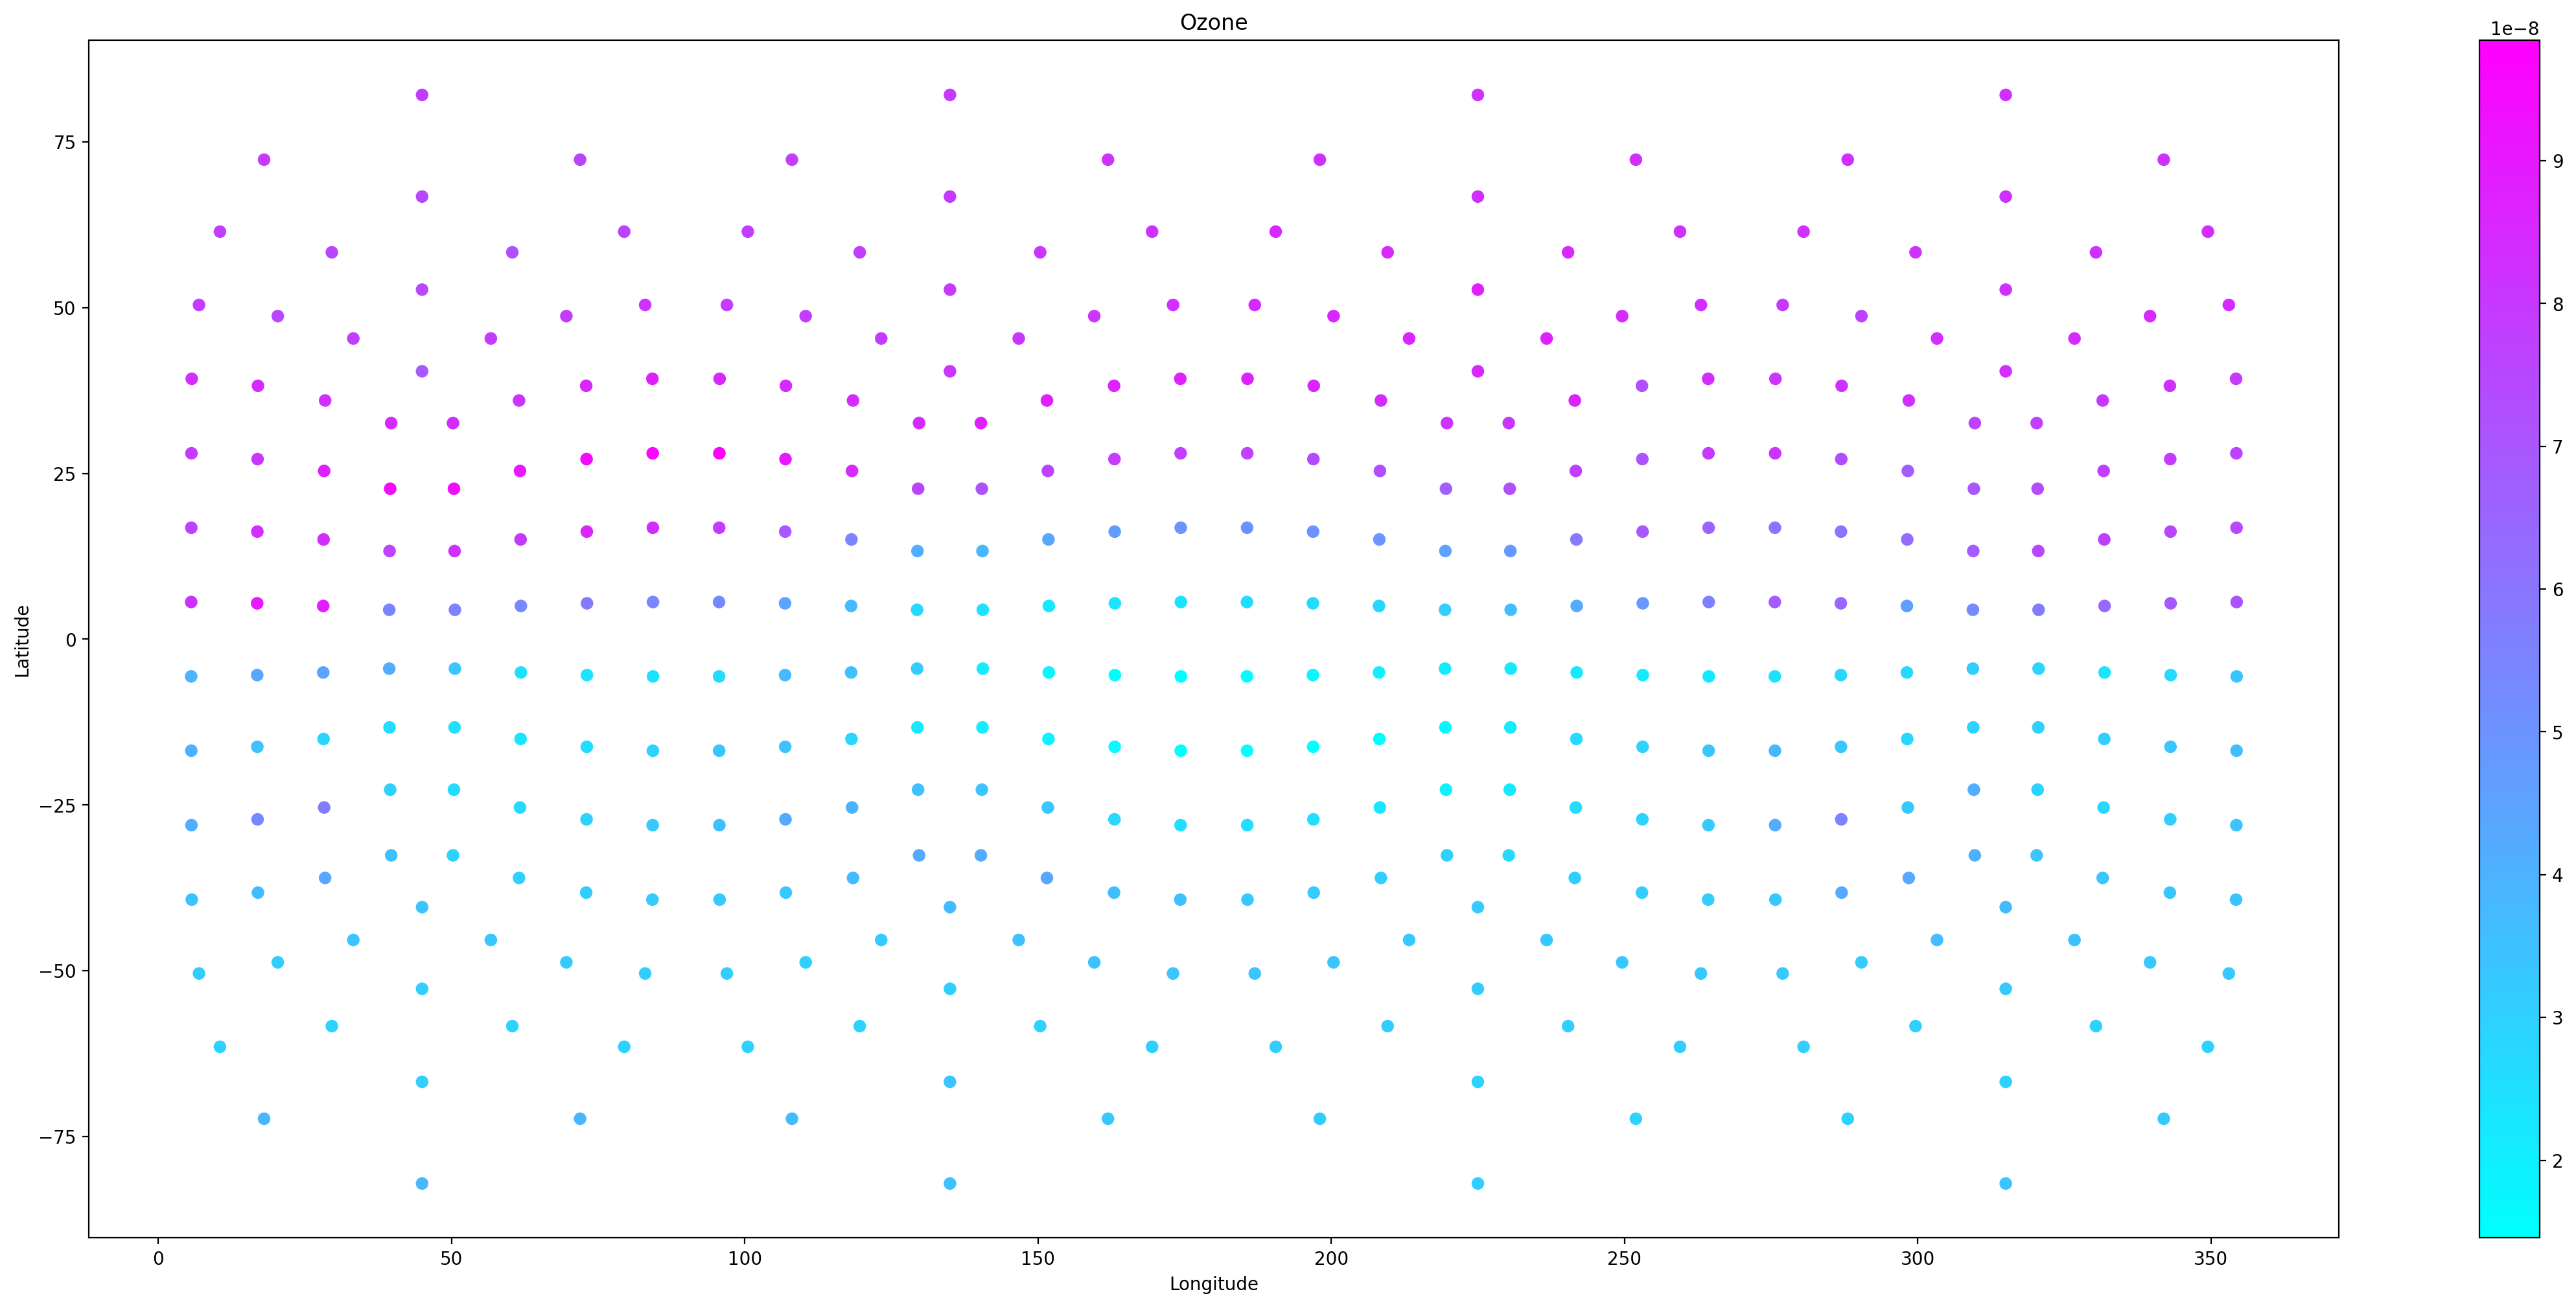

In [151]:

plt.figure(figsize=(28,12))
plt.scatter(grid_info['lon'], grid_info['lat'], c=mli_dataset['pbuf_ozone'][50,:], cmap='cool')
plt.xlabel('Longitude'), plt.ylabel('Latitude'), plt.title('Ozone')
plt.colorbar()

In [152]:
grid_info['lat']

<xarray.DataArray 'lat' (ncol: 384)> Size: 3kB
array([-32.585029, -35.991036, -22.686525, ...,  45.338123,  45.338123,
        40.392282])
Dimensions without coordinates: ncol
Attributes:
    long_name:  latitude
    units:      degrees_north

In [153]:
#calculating the peak ozone level
peak_level = mli_dataset['pbuf_ozone'].argmax(dim='lev', skipna=True)

bins = np.arange(0, 61, 1)


In [154]:
H, xedges, yedges = np.histogram2d(
    x =  grid_info['lat'],
    y = peak_level,
    bins=[len(grid_info['lat']), bins],
    density=True
)

In [155]:
X, Y = np.meshgrid(xedges, yedges)


In [156]:
H.shape

(384, 60)

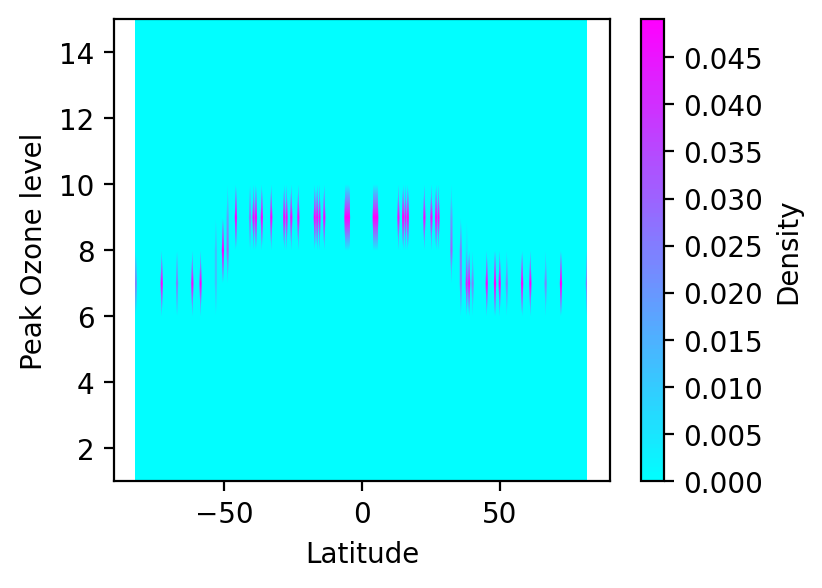

In [157]:
# Generate the contour plot with a logarithmic color scale
fig, ax = plt.subplots(figsize=(4, 3))

cs = ax.contourf(X[:-1, :-1], Y[:-1, :-1], H.T, levels=100, cmap='cool')


# Add a colorbar
cb = fig.colorbar(cs, ax=ax)
cb.set_label('Density')


# Set the limits and labels
ax.set_xlim(-90,90)
ax.set_ylim(1, 15)
ax.set_xlabel('Latitude')
ax.set_ylabel('Peak Ozone level')

# Show the plot
plt.show()

In [158]:
grid_info['lat'].values

array([-32.58502852, -35.99103579, ...,  45.33812314,  40.39228172])

In [159]:
unique_labels, encoded_labels  = np.unique(grid_info['lat'].values, return_inverse =True)

In [160]:
unique_labels[16]

np.float64(-32.58502852348108)

In [161]:
encoded_labels

array([16, 15, ..., 78, 76])

In [162]:
xr.where()

TypeError: where() missing 3 required positional arguments: 'cond', 'x', and 'y'

(array([ 4.,  0.,  8.,  0.,  4.,  0.,  8.,  8.,  4.,  8.,  8.,  8.,  4.,
        16.,  8.,  8., 16.,  8.,  8.,  8., 24.,  0.,  0., 32.,  0.,  0.,
        32.,  0.,  0., 24.,  8.,  8.,  8., 16.,  8.,  8., 16.,  4.,  8.,
         8.,  8.,  4.,  8.,  8.,  0.,  4.,  0.,  8.,  0.,  4.]),
 array([-82.05885901, -78.77650465, -75.49415029, -72.21179593,
        -68.92944157, -65.64708721, -62.36473285, -59.08237849,
        -55.80002413, -52.51766977, -49.23531541, -45.95296105,
        -42.67060669, -39.38825233, -36.10589796, -32.8235436 ,
        -29.54118924, -26.25883488, -22.97648052, -19.69412616,
        -16.4117718 , -13.12941744,  -9.84706308,  -6.56470872,
         -3.28235436,   0.        ,   3.28235436,   6.56470872,
          9.84706308,  13.12941744,  16.4117718 ,  19.69412616,
         22.97648052,  26.25883488,  29.54118924,  32.8235436 ,
         36.10589796,  39.38825233,  42.67060669,  45.95296105,
         49.23531541,  52.51766977,  55.80002413,  59.08237849,
         62.

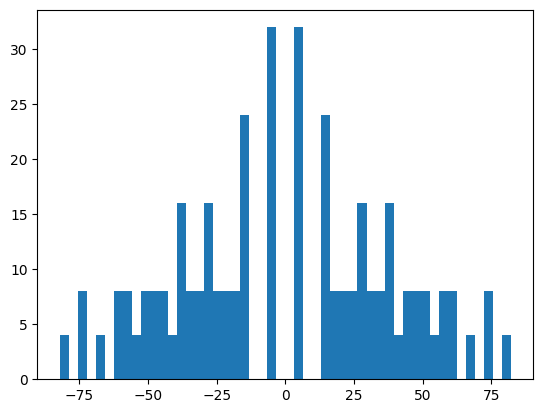

In [ ]:
plt.hist(grid_info['lat'].values, bins = 50)

In [115]:
#marks all the places with non nans
values = xr.where(np.isnan(mli_dataset['pbuf_ozone']), 1, 0)


In [165]:
mli_dataset['pbuf_ozone'].sel(lev=50)

<xarray.DataArray 'pbuf_ozone' (ncol: 384)> Size: 3kB
array([3.417596e-08, 3.292194e-08, 2.962780e-08, ..., 7.910085e-08,
       8.071357e-08, 8.097553e-08])
Dimensions without coordinates: ncol

In [ ]:
def plot_map(values, title_text):
    # Create a figure and axis with a Robinson projection
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6)
    )

    # Add filled contours to the map
    contour = ax.tricontourf(
        lon, lat, values, 
        transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
        cmap='coolwarm',  # Adjust colormap as needed
        levels=20,  # Number of contour levels
        extend='both'  # Extend beyond data range
    )

    # Add features like coastlines and borders
    ax.coastlines(linewidth=0.5, color='black')

    # Add a colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.set_label('Temperature (K)')  # Adjust label to match your data

    # Set title
    ax.set_title('Global ' + title_text + ' - Robinson Projection', fontsize=16)
    ax.set_global()

    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    # Show the plot
    plt.show()

In [2]:

import data_evaluation
data_evaluation.main()


FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/k/kfrields/ClimSim_low-res_grid-info.nc'

In [3]:
import pstats
from pstats import SortKey

p = pstats.Stats('profile_output')

In [4]:
p.print_stats()

Thu Jan 30 09:24:34 2025    profile_output

         1987330 function calls (1947458 primitive calls) in 4.543 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {method 'append' of 'bytearray' objects}
        6    0.000    0.000    0.000    0.000 {method 'decode' of 'bytearray' objects}
        1    0.000    0.000    0.000    0.000 {method 'extend' of 'bytearray' objects}
     2635    0.000    0.000    0.000    0.000 {method 'find' of 'bytearray' objects}
      236    0.000    0.000    0.000    0.000 {method 'translate' of 'bytearray' objects}
        6    0.000    0.000    0.000    0.000 {method 'count' of 'bytes' objects}
     3069    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
       22    0.000    0.000    0.000    0.000 {method 'join' of 'bytes' objects}
        2    0.000    0.000    0.000    0.000 {built-in method maketrans}
        8    0.000

In [5]:
p.sort_stats(SortKey.CUMULATIVE).print_stats('__main__')

Thu Jan 30 09:24:34 2025    profile_output

         1987330 function calls (1947458 primitive calls) in 4.543 seconds



In [6]:
p.sort_stats(SortKey.TIME).print_stats(10)

Thu Jan 30 09:24:34 2025    profile_output

         1987330 function calls (1947458 primitive calls) in 4.543 seconds

   Ordered by: internal time
   List reduced from 7419 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.422    3.422    3.481    3.481 {built-in method matplotlib.backends._macosx.show}
        2    0.178    0.089    0.178    0.089 {method 'read' of '_ssl._SSLSocket' objects}
        1    0.061    0.061    0.085    0.085 /Users/katiefrields/Documents/GitHub/climsim3/.conda/lib/python3.11/site-packages/matplotlib/backend_bases.py:2646(create_with_canvas)
  104/101    0.050    0.000    0.053    0.001 {built-in method _imp.create_dynamic}
      868    0.049    0.000    0.049    0.000 {built-in method marshal.loads}
     7554    0.036    0.000    0.057    0.000 /Users/katiefrields/Documents/GitHub/climsim3/.conda/lib/python3.11/inspect.py:863(cleandoc)
        1    0.026    0.026    0.026    0.026 {built